In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from sklearn.tree import export_graphviz

import graphviz

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score

from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf

from statsmodels.tools.eval_measures import rmse

matplotlib.rc('font', family = 'Noto Sans CJK JP')
matplotlib.rc('axes', unicode_minus = False)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# 0) domain knowledge

### 도메인 지식

- 일반적으로 콘크리트의 강도하면 압축강도를 말한다. 이러한 강도에 영향을 미치는 주된 요인은 사용재료의 품질(시멘트, 골재, 혼합수 등), 배합(물시멘트비, 시멘트물비, 시멘트공극비 등), 공기량, 시공밥법, 온도 등이 있다. 

# 과제물 1 - 의사결정나무_예측

- 콘크리트 강도를 예측하는 의사결정나무 모델을 만들고 predict method를 이용하여 예측값을 구하라.

In [2]:
df_raw = pd.read_csv('/home/piai/test/2. Big Data 분석/Concrete.csv')

In [3]:
df_raw

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


- blast-furnace slag(설명변수) : 고로슬래그로 용광로에서 나온 용철슬래그를 물이나 증기로 급냉하여 유리질의 입상물을 만든 다음 건조시켜 미세한 분말로 얻은 것이다. 

- fly_ash(설명변수) : 화력발전소에서 석탄을 원료로 하는 미분탄을 고온으로 소각시켰을 때 발생되는 먼지이다. 일반적으로 콘크리트에 안들어간 것보다 들어간 것이 단단하다고 한다.
- water(설명변수) : 다른 재료들을 섞기 위해 꼭 필요한 요소이다. 일반적으로 물-시멘트비가 클수록 만들어지는 콘크리트의 압축강도가 감소한다고 한다.
- superplasticizer(설명변수) : 고범위 감수제로도 알려진 수퍼 가소제는 고강도 콘크리트를 만드는데 사용되는 첨가물이다. 이것은 수분함량을 30% 이상 줄일 수 있다고 한다. 
- coarse_aggregate(설명변수) : 작은크기로 부서지고 모양이 불규칙한 돌이다. 콘크리트의 필수 성분 중 하나이며 콘크리트 믹스에서 많은 부피를 차지한다. 
- fine_aggregate(설명변수) : 땅에서 얻은 모든 천연 모래입자로 고도로 압축 가능한 표면이 필요한 곳에 사용된다.

- age(설명변수) : 콘크리트의 수명은 옥외의 경우 평균 50mm일 경우 180년, 실내의 경우 평균 30mm일 경우 65년에 달한다고 한다. 

- strength(목표변수) : 콘크리트의 강도이다.

In [4]:
df_raw.isnull().sum()

cement                0
blast_furnace_slag    0
fly_ash               0
water                 0
superplasticizer      0
coarse_aggregate      0
fine_aggregate        0
age                   0
strength              0
dtype: int64

- 콘크리트 데이터에 결측값이 없는 것을 확인

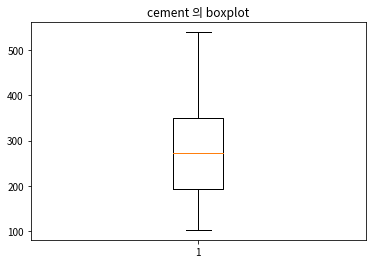

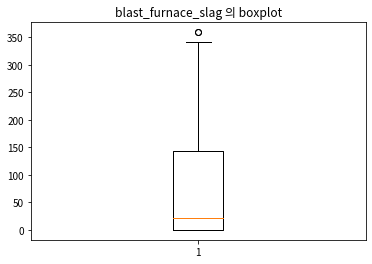

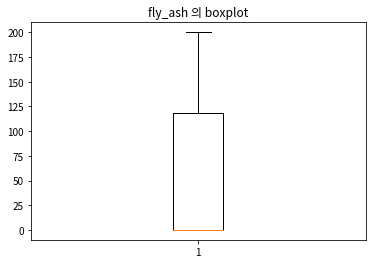

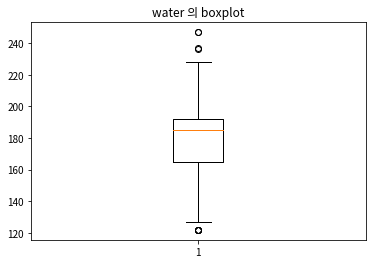

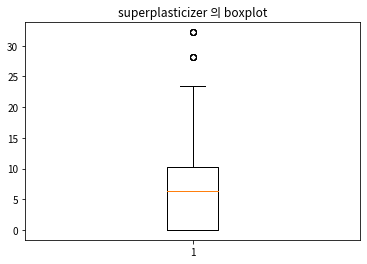

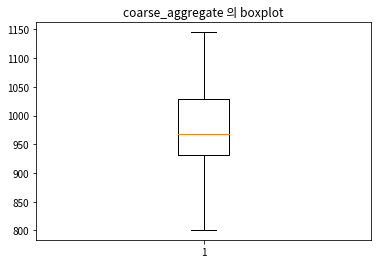

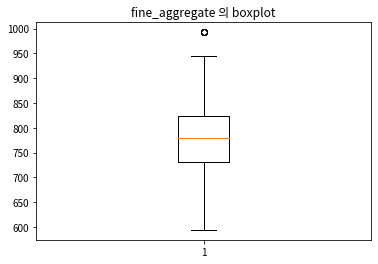

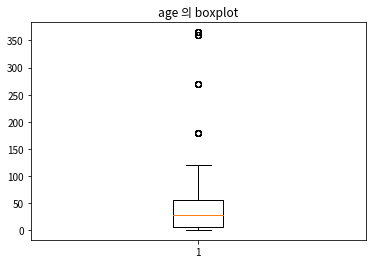

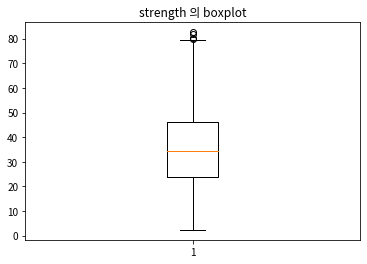

In [5]:
for i in df_raw.columns:
    plt.boxplot(df_raw[i])
    plt.title('{} 의 boxplot'.format(i))
    plt.show()

- 콘크리트 도메인 전문가가 아니기 때문에 이상치는 처리했다고 가정하고 모델링 진행

In [6]:
# 예측하고자 하는 Y가 cement
df_raw_y = df_raw['strength']
df_raw_x = df_raw.drop('strength', axis=1, inplace=False)

## train data와 test data를 0.6,0.4비율로 나눈다.
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size=0.4, random_state=1234)

print('train data X size :{}'.format(df_train_x.shape))
print('train data Y size :{}'.format(df_train_y.shape))
print('test data X size :{}'.format(df_test_x.shape))
print('test data Y size :{}'.format(df_test_y.shape))

train data X size :(618, 8)
train data Y size :(618,)
test data X size :(412, 8)
test data Y size :(412,)


- train data는 618건, test data는 412건이 있다

In [7]:
tree_uncustomized = DecisionTreeRegressor(random_state=1234)
tree_uncustomized.fit(df_train_x, df_train_y)

print('Score on training set:{:.3f}'.format(tree_uncustomized.score(df_train_x, df_train_y)))
print('Score on test set:{:.3f}'.format(tree_uncustomized.score(df_test_x, df_test_y)))

Score on training set:0.996
Score on test set:0.790


- 파라미터를 조정하지 않고 default값을 넣었을때 train dataset은 1.0이 나온 것을 보아 과적합이 일어났다. 하지만 test dataset에서도 나쁘지 않은 성능을 보인다

## 1-1) min_sample_leaf 조정

In [8]:
train_score = []; test_score = []
para_leaf = [n_leaf * 1 for n_leaf in range(1,20)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(random_state=1234, min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score

In [9]:
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.996,0.790
1,2,0.978,0.783
2,3,0.959,0.786
3,4,0.943,0.796
4,5,0.934,0.811
5,6,0.920,0.810
6,7,0.909,0.799
7,8,0.900,0.792
8,9,0.877,0.817
9,10,0.868,0.816


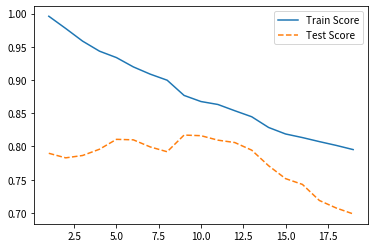

In [10]:
plt.plot(para_leaf ,train_score, linestyle='-', label ='Train Score')
plt.plot(para_leaf ,test_score, linestyle='--', label ='Test Score')
plt.legend()

- train score는 min_sample_leaf가 늘어날수록 떨어지지만 test score는 9일때 가장 높다. 그렇기 때문에 min_sample_leaf를 9로 설정한다.

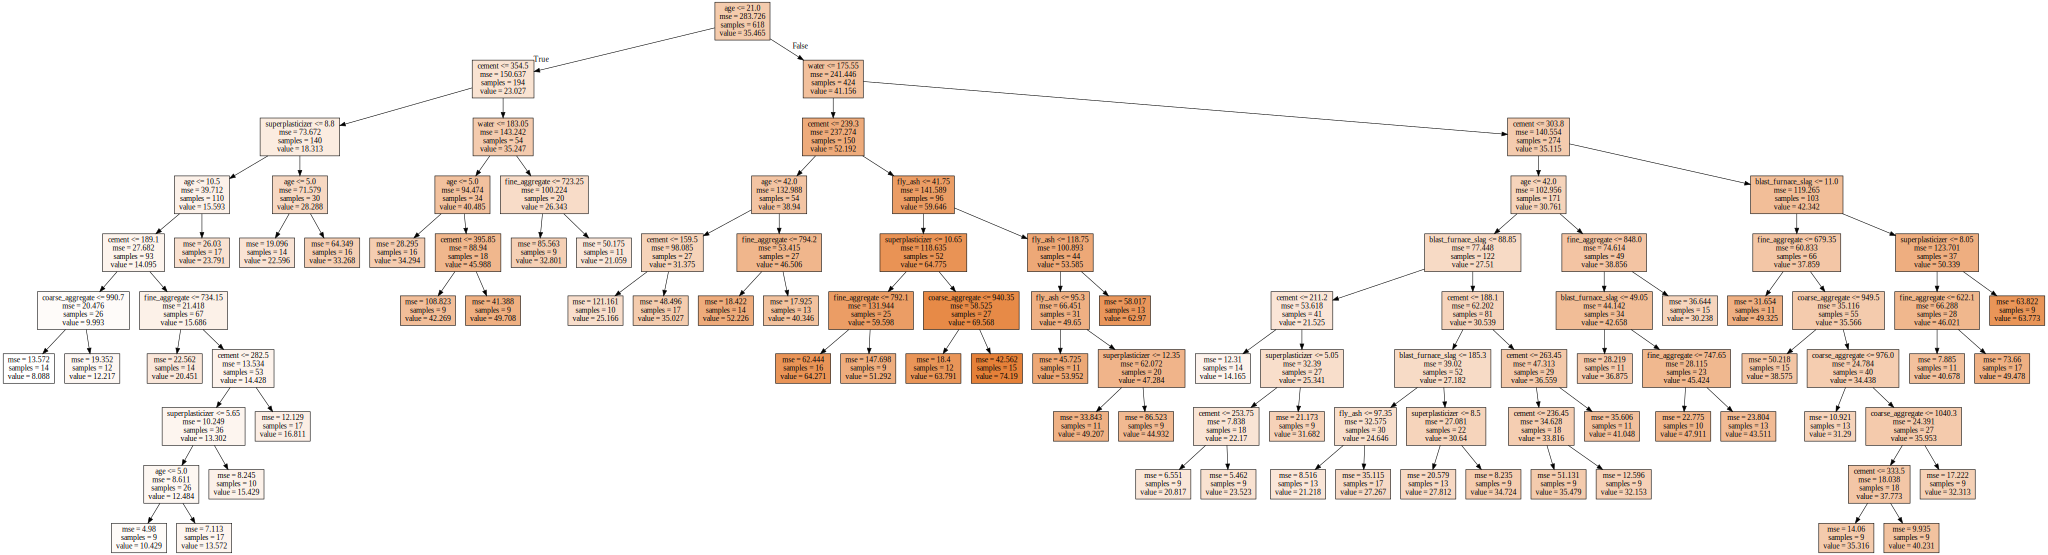

In [11]:
v_feature_name = df_train_x.columns

tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=9)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file = 'tree_leaf.dot', feature_names=v_feature_name, impurity=True, filled=True)
with open('tree_leaf.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

## 1-2) min_samples_split 조정

In [12]:
train_score = []; test_score = []
para_split = [n_split * 2 for n_split in range(1,20)]

for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor(random_state=1234, min_samples_leaf= 9 , min_samples_split = v_min_samples_split)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score

In [13]:
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,2,0.877,0.817
1,4,0.877,0.817
2,6,0.877,0.817
3,8,0.877,0.817
4,10,0.877,0.817
5,12,0.877,0.817
6,14,0.877,0.817
7,16,0.877,0.817
8,18,0.877,0.817
9,20,0.874,0.817


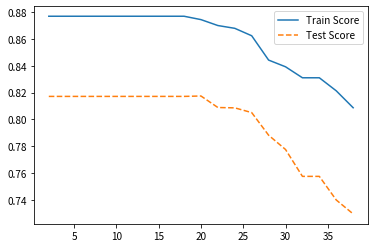

In [15]:
plt.plot(para_split ,train_score, linestyle='-', label ='Train Score')
plt.plot(para_split ,test_score, linestyle='--', label ='Test Score')
plt.legend()

- min_samples_split이 20을 기준으로 train score가 떨어지고 test score는 22를 기준으로 떨어진다. 그렇기 때문에 min_samples_split을 20으로 설정한다.

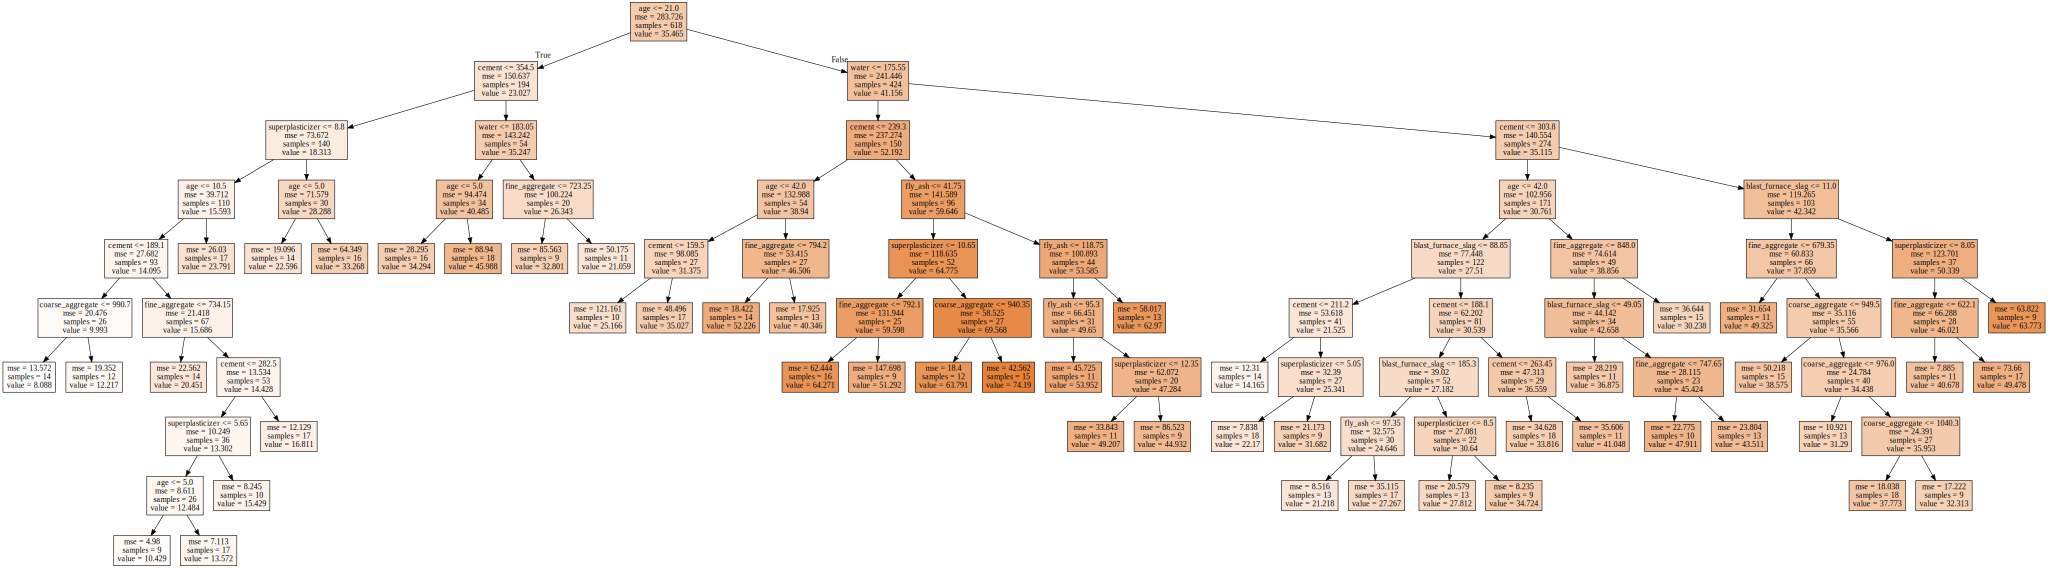

In [14]:
tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=9, min_samples_split=20)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file = 'tree_split.dot', feature_names=v_feature_name, impurity=True, filled=True)
with open('tree_split.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

## 1-3) max_depth 조정

In [15]:
train_score = []; test_score = []
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree = DecisionTreeRegressor(random_state=1234, min_samples_leaf= 9 , min_samples_split = 20, max_depth = v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

df_score_depth = pd.DataFrame()
df_score_depth['Depth'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore'] = test_score

In [16]:
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.249,0.243
1,2,0.474,0.406
2,3,0.644,0.567
3,4,0.749,0.689
4,5,0.821,0.746
5,6,0.859,0.805
6,7,0.870,0.817
7,8,0.874,0.817
8,9,0.874,0.817
9,10,0.874,0.817


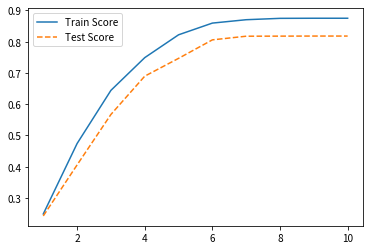

In [17]:
plt.plot(para_depth ,train_score, linestyle='-', label ='Train Score')
plt.plot(para_depth ,test_score, linestyle='--', label ='Test Score')
plt.legend()

- max_depth가 8에서부터 train data가 수렴하고, test data는 7에서부터 수렴한다. max_depth가 너무 커지면 트리가 너무 깊어지기 때문에 과적합이 일어나는 것을 방지하기 위해 7로 설정한다.

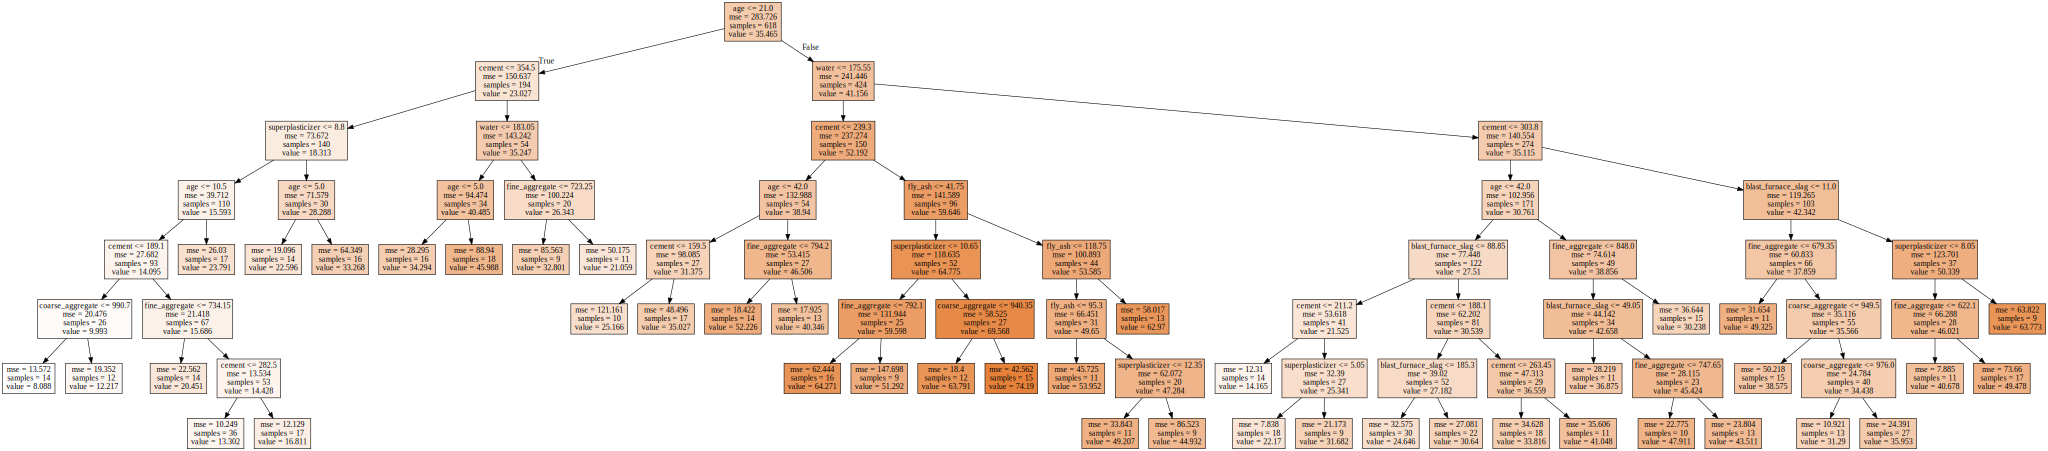

In [19]:
tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=9, min_samples_split=20, max_depth=7)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file = 'tree_depth.dot', feature_names=v_feature_name, impurity=True, filled=True)
with open('tree_depth.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

## 1-4) 선택한 하이퍼파라미터를 모델에 넣어 최종 모델 생성

In [24]:
tree_final = DecisionTreeRegressor(min_samples_leaf=9, min_samples_split=20, max_depth=7, random_state=1234)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeRegressor(max_depth=7, min_samples_leaf=9, min_samples_split=20,
                      random_state=1234)

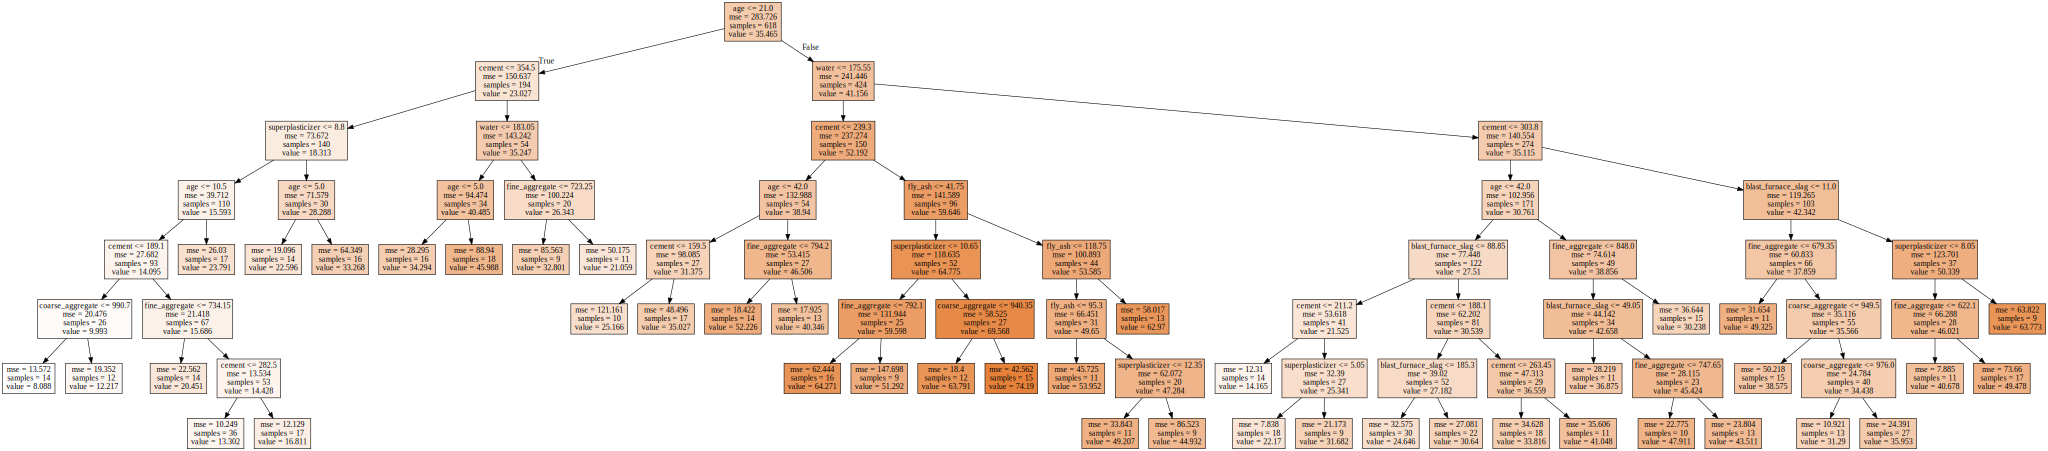

In [25]:
export_graphviz(tree_final, out_file = 'tree_final.dot', feature_names=v_feature_name, impurity=True, filled=True)

with open('tree_final.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# 1-5) feature 중요도

In [26]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = tree_final.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
7,age,0.359
0,cement,0.257
3,water,0.202
4,superplasticizer,0.052
6,fine_aggregate,0.046
1,blast_furnace_slag,0.045
2,fly_ash,0.032
5,coarse_aggregate,0.008


Text(0, 0.5, '변수')

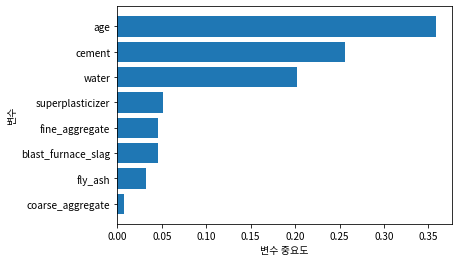

In [27]:
df_importance.sort_values('Importance', ascending=True, inplace =True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

- 콘크리트 강도를 예측하는데에 가장 중요한 변수는 age, cement, water, superplasticizer 순으로 나왔다. 이는 콘트리트의 강도에는 노후화, 시멘트, 물의 영향이 크다고 해석할 수 있다.

In [28]:
print('train_data 성능 :', tree_final.score(df_train_x, df_train_y))


print('test_data 성능 :', tree_final.score(df_test_x, df_test_y))


train_data 성능 : 0.869651234983765
test_data 성능 : 0.816983781691004


- 기존의 default로 모델을 설정하였을 때보다 train_data의 성능은 낮아졌지만 test_data의 성능이 많이 올라간 것을 알 수 있다. 이는 모델이 default모델과는 달리 train_data에만 과적합되지 않고 일반화가 되었다는 것을 의미한다.

In [29]:
estimator = DecisionTreeRegressor(random_state = 1234)

param_grid = {'criterion' : ['mse', 'friedman_mse', 'mae'],
             'max_features' : ['auto', 'sqrt', 'log2'],
             'max_depth' : para_depth,
             'min_samples_split' : para_split,
             'min_samples_leaf' : para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring='r2', n_jobs=-1)
grid_dt.fit(df_train_x, df_train_y)

print('best estimator model: \n{}'.format(grid_dt.best_estimator_))
print('\nbest parameter: \n{}'.format(grid_dt.best_params_))
print('\nbest score: \n{}'.format(grid_dt.best_score_.round(3)))

best estimator model: 
DecisionTreeRegressor(max_depth=10, max_features='auto', min_samples_leaf=3,
                      random_state=1234)

best parameter: 
{'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2}

best score: 
0.795


In [30]:
score_with_test_data = grid_dt.best_estimator_.score(df_test_x, df_test_y)

print('grid search를 통한 test data의 생성 모델 성능 :',score_with_test_data)

grid search를 통한 test data의 생성 모델 성능 : 0.794850204926403


- grid search를 통해 찾은 best parameter의 train, test 성능은 서로 차이가 별로 없어 일반화 되었다고 판단되지만 직접 파라미터를 설정한 모델보다 낮기 때문에 직접설정한 모델을 사용한다. 

# 과제물 2_랜덤 포레스트_예측

- 콘크리트 강도를 예측하는 의사결정나무 모델을 만들고 predict method를 이용하여 예측값을 구하라.

In [38]:
rf_uncustomized = RandomForestRegressor(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)

print('Score on training set:{:.3f}'.format(rf_uncustomized.score(df_train_x, df_train_y)))

print('Score on test set:{:.3f}'.format(rf_uncustomized.score(df_test_x, df_test_y)))

Score on training set:0.980
Score on test set:0.904


- 하이퍼파라미터를 default로 설정한 random-forest의 성능은 train_data와 test_data 모두 높은 성능을 보인다. 하지만 train data의 성능이 거의 1에 가깝기 때문에 과적합을 의심해 볼 수 있다.

## 2-1) n_estimator

In [39]:
train_score = []; test_score = []
para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimator in para_n_tree:
    rf = RandomForestRegressor(random_state=1234, n_estimators = v_n_estimator)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

df_score_n = pd.DataFrame()
df_score_n['n_estimator'] = para_n_tree
df_score_n['TrainScore'] = train_score
df_score_n['TestScore'] = test_score

In [40]:
df_score_n.round(3)

,n_estimator,TrainScore,TestScore
0,10,0.973,0.905
1,20,0.978,0.905
2,30,0.979,0.903
3,40,0.979,0.905
4,50,0.980,0.905
5,60,0.980,0.906
6,70,0.980,0.906
7,80,0.980,0.906
8,90,0.980,0.905
9,100,0.980,0.904


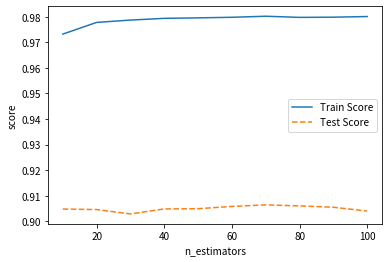

In [34]:
plt.plot(para_n_tree ,train_score, linestyle='-', label ='Train Score')
plt.plot(para_n_tree ,test_score, linestyle='--', label ='Test Score')
plt.ylabel('score'); plt.xlabel('n_estimators')
plt.legend()

- randomForest에서 n_estimator의 값은 늘어날수록 성능은 좋아지지만 과적합의 위험이 크다. 그러므로 train score가 수렴하는 50과 test score가 수렴하는 60 중 50을 선택한다

## 2-2) min_samples_leaf 조정

In [47]:
train_score = []; test_score = []
para_leaf = [n_leaf * 2 for n_leaf in range(1,20)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestRegressor(random_state=1234, n_estimators = 50, min_samples_leaf = v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score

In [48]:
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,2,0.967,0.900
1,4,0.938,0.878
2,6,0.913,0.857
3,8,0.895,0.846
4,10,0.876,0.823
5,12,0.860,0.806
6,14,0.848,0.796
7,16,0.836,0.785
8,18,0.824,0.774
9,20,0.812,0.762


In [49]:
df_score_leaf["lag_1_train"] = df_score_leaf["TrainScore"].diff(1)
df_score_leaf["lag_1_test"] = df_score_leaf["TestScore"].diff(1)

In [50]:
df_score_leaf

,MinSamplesLeaf,TrainScore,TestScore,lag_1_train,lag_1_test
0,2,0.966800,0.899573,NaN,NaN
1,4,0.938323,0.877875,-0.028477,-0.021698
2,6,0.912516,0.856704,-0.025807,-0.021171
3,8,0.895277,0.845792,-0.017239,-0.010912
4,10,0.876192,0.823302,-0.019085,-0.022490
5,12,0.860383,0.806145,-0.015809,-0.017157
6,14,0.848025,0.795564,-0.012359,-0.010581
7,16,0.836285,0.784702,-0.011739,-0.010861
8,18,0.824340,0.774358,-0.011946,-0.010345
9,20,0.812425,0.761672,-0.011915,-0.012686


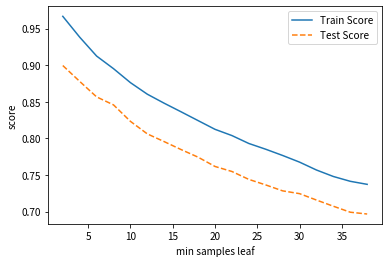

In [51]:
plt.plot(para_leaf ,train_score, linestyle='-', label ='Train Score')
plt.plot(para_leaf ,test_score, linestyle='--', label ='Test Score')
plt.ylabel('score'); plt.xlabel('min samples leaf')
plt.legend()

- train_data와 test_data score가 min samples leaf가 늘어날수록 낮아지기 때문에 차분을 통해 기울기의 완만한 정도를 계산하고 score가 높고 기울기 또한 완만한 편인 8를 min samples leaf로 설정한다.

## 2-3) min_samples_split 조정

In [55]:
train_score = []; test_score = []
para_split = [n_split * 2 for n_split in range(1,20)]

for v_min_samples_split in para_split:
    rf = RandomForestRegressor(random_state=1234, n_estimators = 50, min_samples_split = v_min_samples_split, min_samples_leaf=8)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

df_score_split = pd.DataFrame()
df_score_split['MinSamplessplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score

In [56]:
df_score_split.round(3)

,MinSamplessplit,TrainScore,TestScore
0,2,0.895,0.846
1,4,0.895,0.846
2,6,0.895,0.846
3,8,0.895,0.846
4,10,0.895,0.846
5,12,0.895,0.846
6,14,0.895,0.846
7,16,0.895,0.846
8,18,0.891,0.840
9,20,0.885,0.833


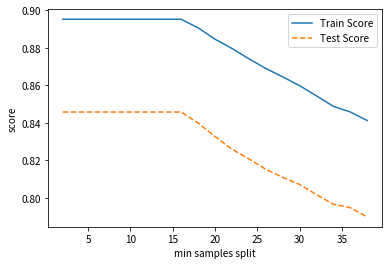

In [57]:
plt.plot(para_split ,train_score, linestyle='-', label ='Train Score')
plt.plot(para_split ,test_score, linestyle='--', label ='Test Score')
plt.ylabel('score'); plt.xlabel('min samples split')
plt.legend()

- min samples split의 값이 16 보다 커지면 train, test data 모두 score가 낮아지는 것을 알 수 있다. 그렇기 때문에 min samples split의 값을 16으로 설정한다.

## 2-4) max_depth 조정

In [58]:
train_score = []; test_score = []
para_depth = [n_depth * 2 for n_depth in range(1,20)]

for v_max_depth in para_depth:
    rf = RandomForestRegressor(random_state=1234, n_estimators = 50, min_samples_split = 16, min_samples_leaf=8, max_depth = v_max_depth)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

df_score_depth = pd.DataFrame()
df_score_depth['Depth'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore'] = test_score

In [60]:
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,2,0.612,0.591
1,4,0.810,0.766
2,6,0.883,0.838
3,8,0.894,0.846
4,10,0.895,0.846
5,12,0.895,0.846
6,14,0.895,0.846
7,16,0.895,0.846
8,18,0.895,0.846
9,20,0.895,0.846


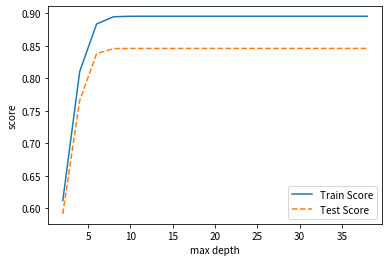

In [61]:
plt.plot(para_depth ,train_score, linestyle='-', label ='Train Score')
plt.plot(para_depth ,test_score, linestyle='--', label ='Test Score')
plt.ylabel('score'); plt.xlabel('max depth')
plt.legend()

- max depth의 경우 10이상부터 train, test 데이터 모두 같은 값으로 수렴하기 때문에 max_depth를 10으로 설정한다.

## 2-5) 선택한 하이퍼파라미터를 모델에 넣어 최종 모델 생성

In [62]:
rf_final = RandomForestRegressor(min_samples_leaf=8, min_samples_split=16, max_depth=10, random_state=1234, n_estimators=50)
rf_final.fit(df_train_x, df_train_y)

RandomForestRegressor(max_depth=10, min_samples_leaf=8, min_samples_split=16,
                      n_estimators=50, random_state=1234)

In [63]:
print('Score on training set:{:.3f}'.format(rf_final.score(df_train_x, df_train_y)))

print('Score on test set:{:.3f}'.format(rf_final.score(df_test_x, df_test_y)))

Score on training set:0.895
Score on test set:0.846


- 기존 default로 설정하여 randomforest를 돌린것 보다는 성능이 좋지 않지만 train과 test의 성능 차이가 얼마 나지 않고 성능 자체도 좋은 편이므로 모델 선택

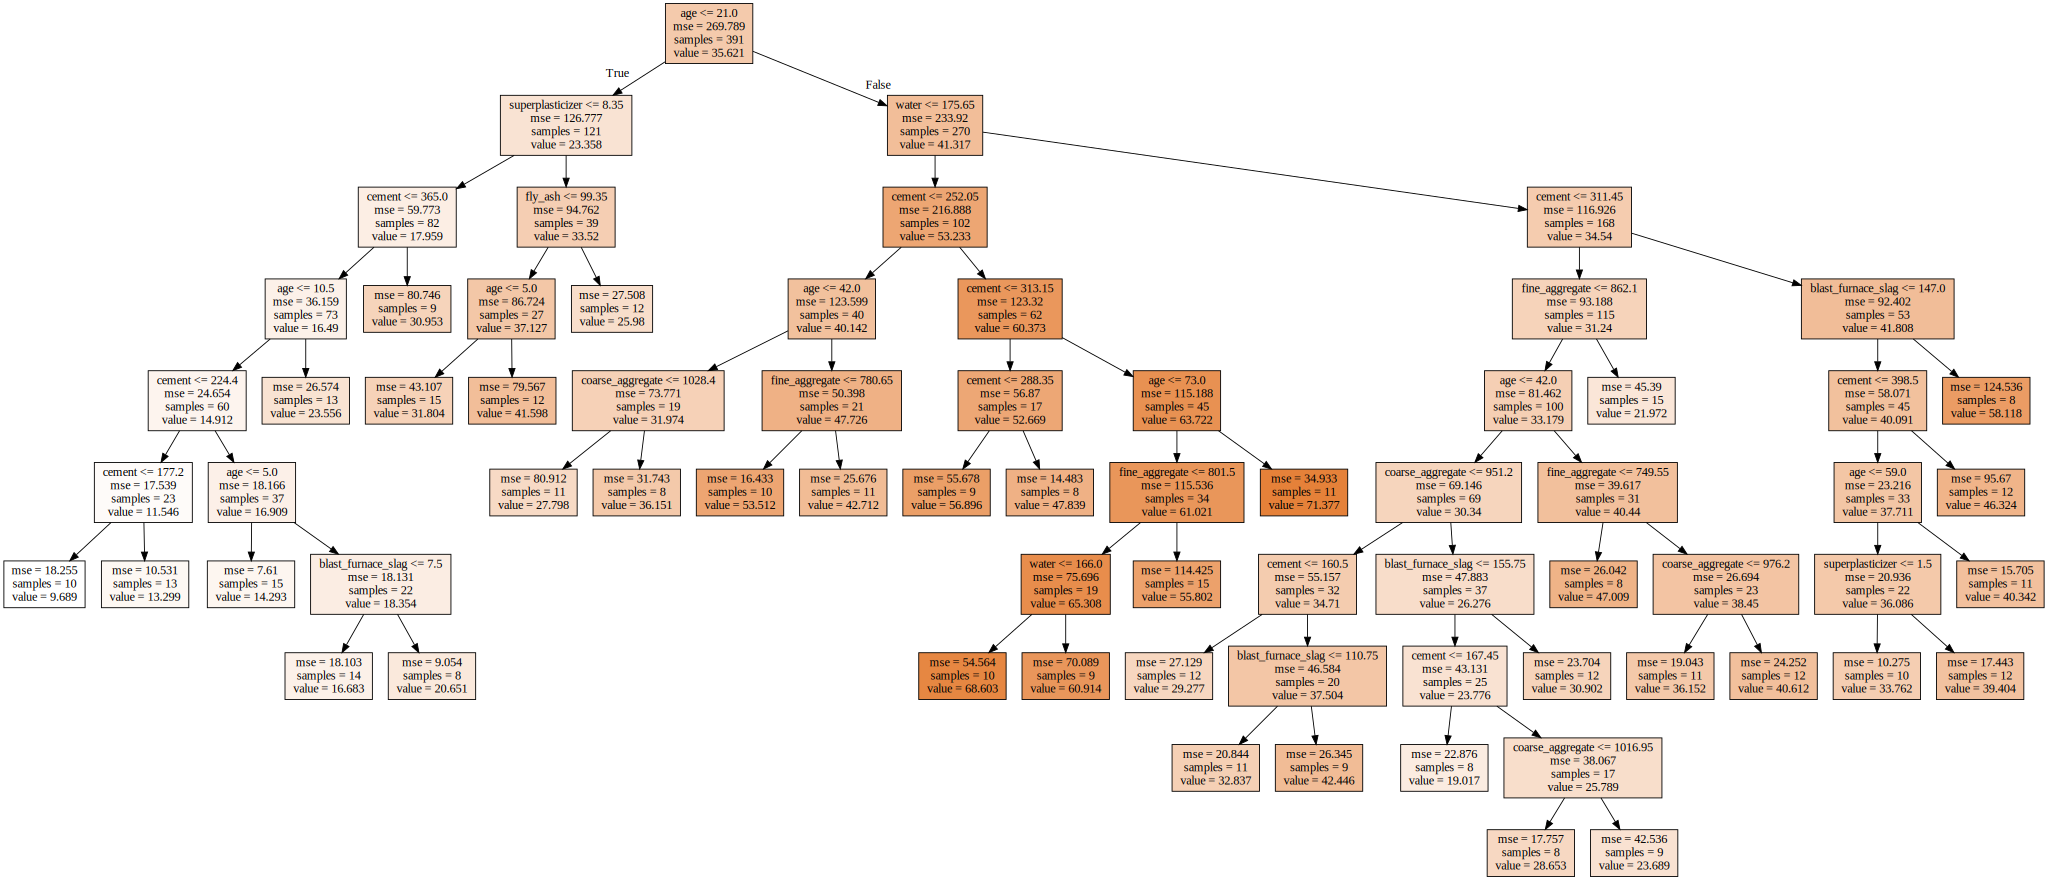

In [64]:
v_feature_name = df_train_x.columns

export_graphviz(rf_final.estimators_[0], out_file = 'rfr_final_0.dot', feature_names=v_feature_name, impurity=True, filled=True)
with open('rfr_final_0.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

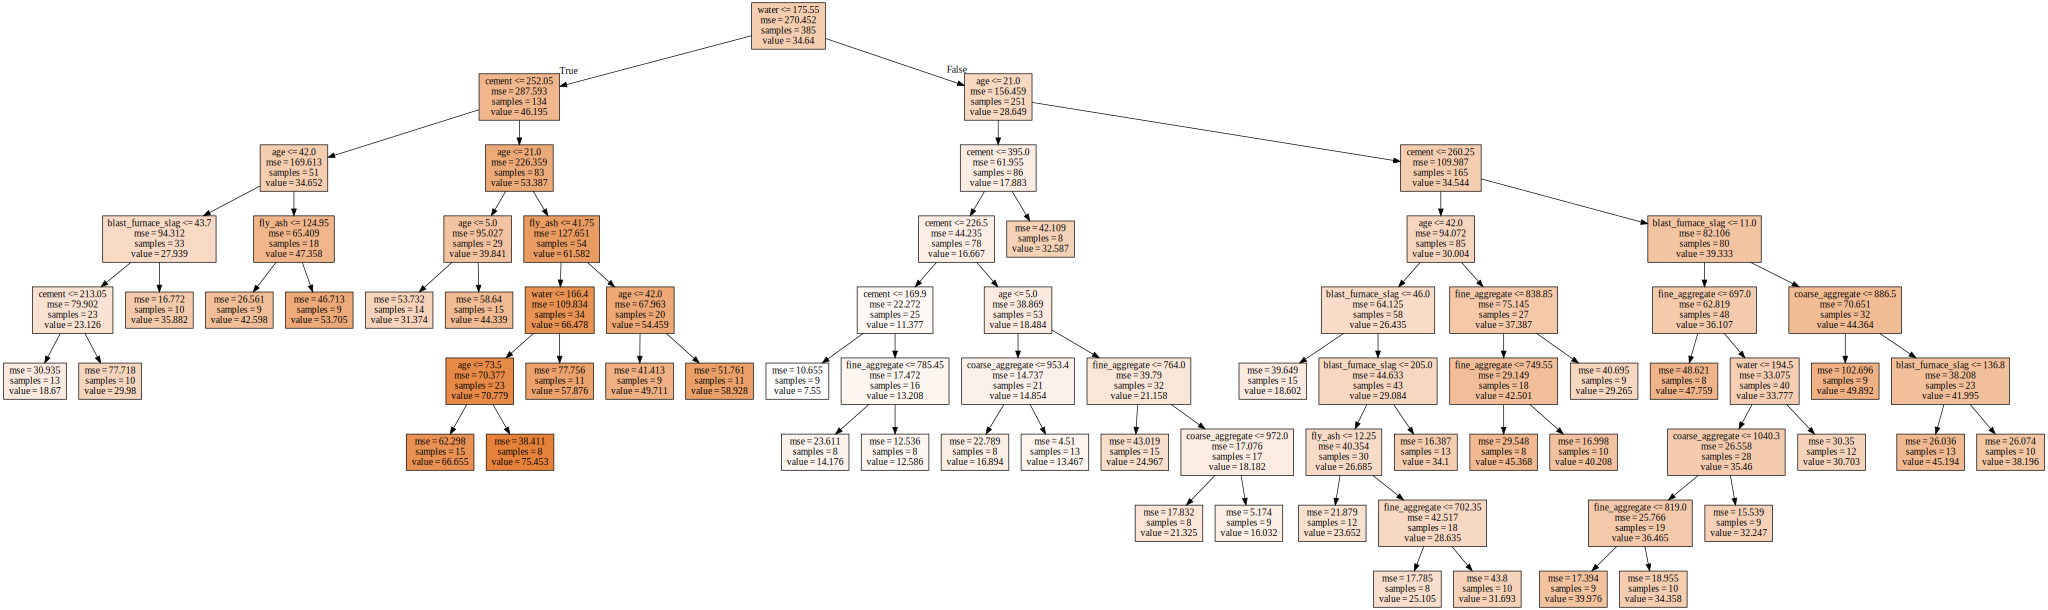

In [65]:
export_graphviz(rf_final.estimators_[1], out_file = 'rfr_final_0.dot', feature_names=v_feature_name, impurity=True, filled=True)
with open('rfr_final_0.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

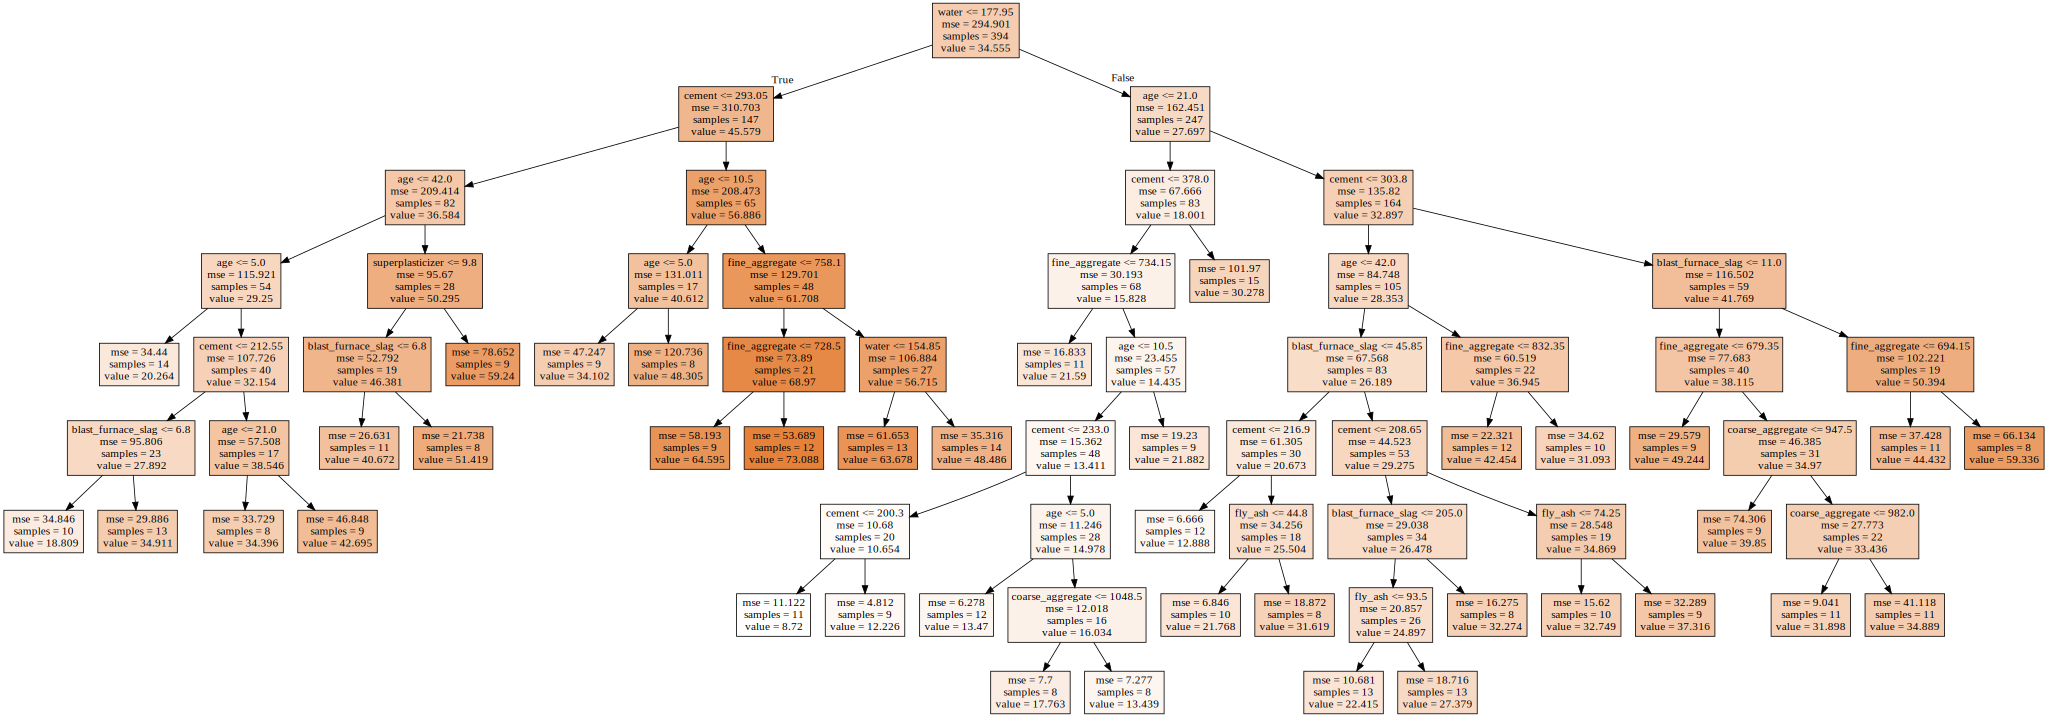

In [66]:
export_graphviz(rf_final.estimators_[10], out_file = 'rfr_final_0.dot', feature_names=v_feature_name, impurity=True, filled=True)
with open('rfr_final_0.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# 6) feature 중요도

In [67]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rf_final.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
7,age,0.381
0,cement,0.274
3,water,0.157
4,superplasticizer,0.079
1,blast_furnace_slag,0.045
6,fine_aggregate,0.038
5,coarse_aggregate,0.016
2,fly_ash,0.010


Text(0, 0.5, '변수')

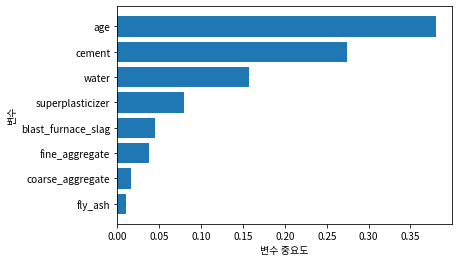

In [68]:
df_importance.sort_values('Importance', ascending=True, inplace =True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

- 콘크리트 강도를 예측하는데에 가장 중요한 변수는 age, cement, water, superplasticizer 순으로 나왔다. 이는 콘트리트의 강도에는 노후화, 시멘트, 물의 영향이 크다고 해석할 수 있다.

# 과제물 3_Gradinet Boosting_예측

- 콘크리트 강도를 예측하는 Gradinet Boosting 모델을 만들고 predict method를 이용하여 예측값을 구하라.

In [71]:
gb_uncustomized = GradientBoostingRegressor(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)

print('Score on training set:{:.3f}'.format(gb_uncustomized.score(df_train_x, df_train_y)))

print('Score on test set:{:.3f}'.format(gb_uncustomized.score(df_test_x, df_test_y)))

Score on training set:0.951
Score on test set:0.915


- 기본 default 모델의 성능도 충분히 좋지만 train data에 너무 적합한 과적합이라고 판단된다.

## 3-1) n_estimator

In [77]:
train_score = []; test_score = []
para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimator in para_n_tree:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators = v_n_estimator)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

df_score_n = pd.DataFrame()
df_score_n['n_estimator'] = para_n_tree
df_score_n['TrainScore'] = train_score
df_score_n['TestScore'] = test_score

In [78]:
df_score_n.round(3)

,n_estimator,TrainScore,TestScore
0,10,0.646,0.621
1,20,0.807,0.773
2,30,0.870,0.835
3,40,0.898,0.863
4,50,0.915,0.878
5,60,0.925,0.888
6,70,0.934,0.898
7,80,0.940,0.904
8,90,0.946,0.910
9,100,0.951,0.915


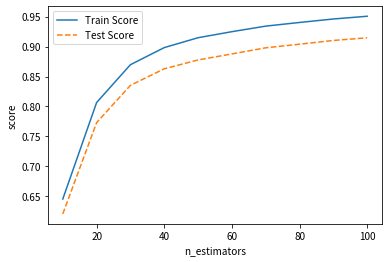

In [79]:
plt.plot(para_n_tree ,train_score, linestyle='-', label ='Train Score')
plt.plot(para_n_tree ,test_score, linestyle='--', label ='Test Score')
plt.ylabel('score'); plt.xlabel('n_estimators')
plt.legend()

- train score와 test score 모두 발산하는 형태를 띈다. 하지만 점점 score가 적게 변하는 것을 볼 수 있고 n_estimator가 커질수록 과적합이 발생할 가능성이 높기 때문에 train score를 기준으로 60 -> 70 에서 0.09 증가하지만 70 -> 80 에서 0.06 증가하기 때문에 70을 n_estimator로 설정한다.

## 3-2) min_samples_leaf 조정

In [80]:
train_score = []; test_score = []
para_leaf = [n_leaf * 2 for n_leaf in range(1,20)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators = 70, min_samples_leaf = v_min_samples_leaf)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score

In [82]:
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,2,0.933,0.895
1,4,0.928,0.894
2,6,0.927,0.899
3,8,0.927,0.896
4,10,0.926,0.894
5,12,0.926,0.896
6,14,0.921,0.894
7,16,0.919,0.894
8,18,0.919,0.891
9,20,0.918,0.889


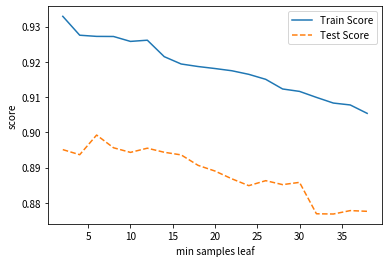

In [81]:
plt.plot(para_leaf ,train_score, linestyle='-', label ='Train Score')
plt.plot(para_leaf ,test_score, linestyle='--', label ='Test Score')
plt.ylabel('score'); plt.xlabel('min samples leaf')
plt.legend()

- MinSamplesLeaf가 4 -> 6 을 보면 TestScore가 증가하고 상대적으로 TrainScore도 많이 낮아지지 않은것을 볼 수 있다. 하지만 MinSamplesLeaf가 너무 작은 경우 과적합의 위험이 있기 때문에 그 다음 TrainScore는 유지되고 TestScore가 증가되는 12로 MinSamplesLeaf를 설정한다.

## 3-3) min_samples_split 조정

In [103]:
train_score = []; test_score = []
para_split = [n_split * 2 for n_split in range(1,20)]

for v_min_samples_split in para_split:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators = 70, min_samples_split = v_min_samples_split, min_samples_leaf=12)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

df_score_split = pd.DataFrame()
df_score_split['MinSamplessplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score

In [104]:
df_score_split.round(3)

,MinSamplessplit,TrainScore,TestScore
0,2,0.926,0.896
1,4,0.926,0.896
2,6,0.926,0.896
3,8,0.926,0.896
4,10,0.926,0.896
5,12,0.926,0.896
6,14,0.926,0.896
7,16,0.926,0.896
8,18,0.926,0.896
9,20,0.926,0.896


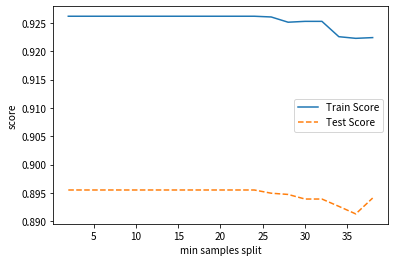

In [105]:
plt.plot(para_split ,train_score, linestyle='-', label ='Train Score')
plt.plot(para_split ,test_score, linestyle='--', label ='Test Score')
plt.ylabel('score'); plt.xlabel('min samples split')
plt.legend()

- MinSamplessplit은 레코드 수가 일정 수 미만이면 분할이 발생하지 않는 것인데 너무 작으면 과대적합이 발생하기 때문에 TrainScore와 TestScore 모두 감소하지 않는 24로 설정한다. 그 이상으로 설정한다면 과소적합이 일어날 수 있어 24로 설정한다.

## 3-4) max_depth 조정

In [106]:
train_score = []; test_score = []
para_depth = [n_depth * 2 for n_depth in range(1,20)]

for v_max_depth in para_depth:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators = 70, min_samples_split = 24, min_samples_leaf=12, max_depth = v_max_depth)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

df_score_depth = pd.DataFrame()
df_score_depth['Depth'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore'] = test_score

In [107]:
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,2,0.886,0.861
1,4,0.951,0.909
2,6,0.971,0.924
3,8,0.979,0.928
4,10,0.982,0.928
5,12,0.982,0.931
6,14,0.983,0.930
7,16,0.983,0.931
8,18,0.984,0.932
9,20,0.984,0.931


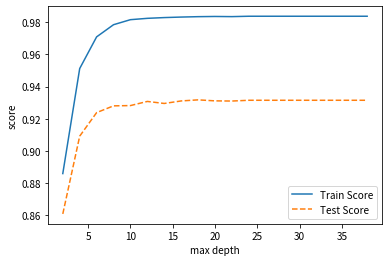

In [108]:
plt.plot(para_depth ,train_score, linestyle='-', label ='Train Score')
plt.plot(para_depth ,test_score, linestyle='--', label ='Test Score')
plt.ylabel('score'); plt.xlabel('max depth')
plt.legend()

- TrainScore 와 TestScore 모두 수렴하는 형태를 띄지만 TestScore에서 max_depth가 12일 때를 보면 max_depth가 14로 높아진 경우에 score가 낮아지기 때문에 max_depth를 12로 설정한다. 더 깊어지면 과적합이 발생할 수 있기 때문에 12로 설정한다.

## 3-5) learing rate 조정

In [109]:
train_score = []; test_score = []
para_lr = [lr * 0.1 for lr in range(1,10)]

for v_learning_rat in para_lr:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators = 70, min_samples_split = 24, min_samples_leaf=12, max_depth = 12, learning_rate=v_learning_rat)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

df_score_lr = pd.DataFrame()
df_score_lr['LearningRate'] = para_lr
df_score_lr['TrainScore'] = train_score
df_score_lr['TestScore'] = test_score

In [110]:
df_score_lr.round(3)

,LearningRate,TrainScore,TestScore
0,0.1,0.982,0.931
1,0.2,0.989,0.932
2,0.3,0.993,0.933
3,0.4,0.994,0.931
4,0.5,0.995,0.929
5,0.6,0.995,0.912
6,0.7,0.995,0.905
7,0.8,0.996,0.899
8,0.9,0.996,0.878


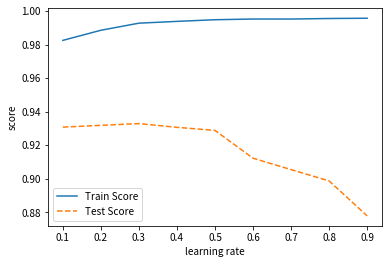

In [111]:
plt.plot(para_lr ,train_score, linestyle='-', label ='Train Score')
plt.plot(para_lr ,test_score, linestyle='--', label ='Test Score')
plt.ylabel('score'); plt.xlabel('learning rate')
plt.legend()

- LearningRate의 경우 train 데이터에서는 발산하는 형태를 띄지만 TestScore를 보면 LearningRate가 0.2 -> 0.3 일때 score가 증가하고 0.3 -> 0.4 일때 score가 감소하는 것을 볼 수 있다. 그렇기 때문에 LearningRate를 0.3로 설정한다.

## 3-6) 선택한 하이퍼파라미터를 모델에 넣어 최종 모델 생성

In [112]:
gb_final = GradientBoostingRegressor(random_state=1234, n_estimators = 70, min_samples_split = 24, min_samples_leaf=12, max_depth = 12, learning_rate=0.3)
gb_final.fit(df_train_x, df_train_y)

GradientBoostingRegressor(learning_rate=0.3, max_depth=12, min_samples_leaf=12,
                          min_samples_split=24, n_estimators=70,
                          random_state=1234)

In [113]:
print('Score on training set :{:.3f}'.format(gb_final.score(df_train_x, df_train_y)))

print('Score on test set :{:.3f}'.format(gb_final.score(df_test_x, df_test_y)))     

Score on training set :0.993
Score on test set :0.933


- 생성된 모델이 train data에서 성능이 너무 좋아 과적합이 의심된다. 또한 train data 와 test data의 차이도 많이 나기 때문에 일반화 되지 못한 올바르지 못한 모델인 것으로 추정된다.

## 3-7) 결론 도출

In [114]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = gb_final.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
7,age,0.330
0,cement,0.271
3,water,0.165
4,superplasticizer,0.073
1,blast_furnace_slag,0.061
6,fine_aggregate,0.049
5,coarse_aggregate,0.029
2,fly_ash,0.021


Text(0, 0.5, '변수')

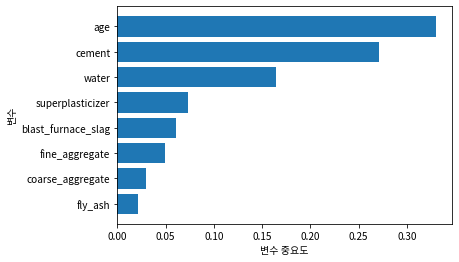

In [115]:
df_importance.sort_values('Importance', ascending=True, inplace =True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

- 콘크리트 강도를 예측하는데에 가장 중요한 변수는 age, cement, water, superplasticizer 순으로 나왔다. 이는 콘트리트의 강도에는 노후화, 시멘트, 물의 영향이 크다고 해석할 수 있다.

# 4. 모델 평가 및 선정(predict)

In [129]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [130]:
dt_model = DecisionTreeRegressor(min_samples_leaf=9, min_samples_split=20, max_depth=7, random_state=1234)
dt_model.fit(df_train_x, df_train_y)

DecisionTreeRegressor(max_depth=7, min_samples_leaf=9, min_samples_split=20,
                      random_state=1234)

In [131]:
rf_model =  RandomForestRegressor(min_samples_leaf=8, min_samples_split=16, max_depth=10, random_state=1234, n_estimators=50)
rf_model.fit(df_train_x, df_train_y)

RandomForestRegressor(max_depth=10, min_samples_leaf=8, min_samples_split=16,
                      n_estimators=50, random_state=1234)

In [132]:
gb_model = GradientBoostingRegressor(random_state=1234, n_estimators = 70, min_samples_split = 24, min_samples_leaf=12, max_depth = 12, learning_rate=0.3)
gb_model.fit(df_train_x, df_train_y)

GradientBoostingRegressor(learning_rate=0.3, max_depth=12, min_samples_leaf=12,
                          min_samples_split=24, n_estimators=70,
                          random_state=1234)

In [133]:
models = ['의사결정나무', '랜덤 포레스트', '그래디언트 부스팅']

mse, rmse, mae, mape = [],[],[],[]

In [134]:
dt_y_pred = dt_model.predict(df_test_x)

mse.append(mean_squared_error(df_test_y, dt_y_pred))
rmse.append(root_mean_squared_error(df_test_y, dt_y_pred))
mae.append(mean_absolute_error(df_test_y, dt_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, dt_y_pred))

In [135]:
rf_y_pred = rf_model.predict(df_test_x)

mse.append(mean_squared_error(df_test_y, rf_y_pred))
rmse.append(root_mean_squared_error(df_test_y, rf_y_pred))
mae.append(mean_absolute_error(df_test_y, rf_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, rf_y_pred))

In [136]:
gb_y_pred = gb_model.predict(df_test_x)

mse.append(mean_squared_error(df_test_y, gb_y_pred))
rmse.append(root_mean_squared_error(df_test_y, gb_y_pred))
mae.append(mean_absolute_error(df_test_y, gb_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, gb_y_pred))

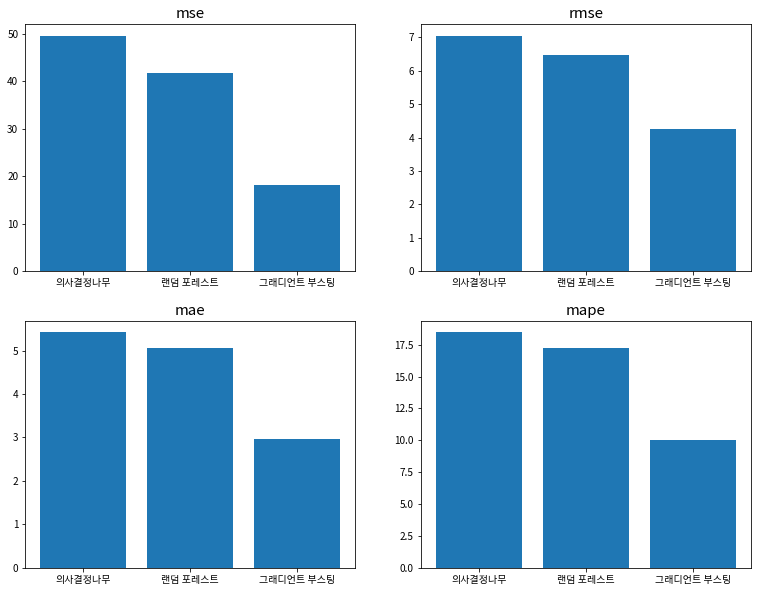

In [137]:
fig, ax = plt.subplots(2,2, figsize =(13,10))
ax[0,0].bar(models, mse)
ax[0,0].set_title('mse').set_fontsize(15)

ax[0,1].bar(models, rmse)
ax[0,1].set_title('rmse').set_fontsize(15)

ax[1,0].bar(models, mae)
ax[1,0].set_title('mae').set_fontsize(15)

ax[1,1].bar(models, mape)
ax[1,1].set_title('mape').set_fontsize(15)

- 평가 지표별 모델의 정확도 추게는 유사하게 나타난다. 최적의 모델을 선정하는 과정에서 GradientBoosting은 모델의 과적합이 의심되지만 DecisionTree, RandomForest의 mse, rmse, mae, mape를 모두 비교해 보았을 때 성능이 GradientBoosting보다 현저히 낮기 때문에 GradientBoosting을 최종 모델로 채택한다. 이후 모델 앙상블과 같은 과정을 통해 과적합을 방지하고 더 나은 성능을 가진 모델을 만들 수 있을 것이라고 판단된다. 